# Text Analysis through Natural Language Processing, Understanding and Classification

# 1 - Importing NLP packages

In [1]:
from wordcloud import WordCloud, STOPWORDS
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar

from gensim import models, corpora
from gensim.sklearn_api import HdpTransformer
from gensim.test.utils import common_dictionary, common_corpus
from gensim.scripts.glove2word2vec import glove2word2vec

from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *

import string
import re
import scipy
import pyLDAvis

import pandas as pd # to dataframes
import matplotlib.pyplot as plt #to define plot parameters
import seaborn as sns #to graphical plots
import numpy as np #to math
plt.style.use('ggplot') # to plot graphs with gggplot2 style

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\dastous\Anaconda3\envs\py3.6\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
EDA=pd.read_excel('../CannaConnect/Dataset/EDA.xlsx')
EDA.head()

,Unnamed: 0,Strain,Type,Rating,Effects,Flavor,Description,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Flavor_1,Flavor_2,Flavor_3,Flavor_4
0,0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,NaN
1,1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,NaN
2,2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,NaN
3,3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,NaN
4,4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,NaN


# 2 - Initial NLP task

In [5]:
#Preprocessing the text in the Description, lower case, taking out special characters and stop words, lemmatization of the words
stopwords = set(STOPWORDS)
df_des=EDA.Description.astype(str)
df_lower_case_des=df_des.apply(lambda x: " ".join(x.lower() for x in x.split())) #lower case
df_special_characters_out_des=df_lower_case_des.map(lambda x: re.sub(r'\W+', ' ',x)) #remove special character
df_stop_words_out_des=df_special_characters_out_des.apply(lambda x: " ".join(x for x in x.split() if x not in stopwords)) #remove stopwords
df_lemma_des=df_stop_words_out_des.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))  #lemmatize
#print the head of the lemmatize description text
print(df_lemma_des.head())

0    100 og 50 50 hybrid strain pack strong punch n...
1    98 aloha white widow especially potent cut whi...
2    1024 sativa dominant hybrid bred spain medical...
3    13 dawgs hybrid g13 chemdawg genetics bred can...
4    known kosher tangie 24k gold 60 indica dominan...
Name: Description, dtype: object


In [6]:
# How many numerical words for each row
df_digits = df_lemma_des.apply(lambda x: len([x for x in x.split() if x.isdigit()]))
print(df_digits.head())
print(df_digits.describe())

0    4
1    2
2    2
3    4
4    3
Name: Description, dtype: int64
count    2349.000000
mean        1.029800
std         1.380985
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         8.000000
Name: Description, dtype: float64


In [7]:
# Taking out the numbers of each description
df_numeric_out = df_lemma_des.str.replace('\\d+', '')
print(df_numeric_out.head())

0     og   hybrid strain pack strong punch name sup...
1     aloha white widow especially potent cut white...
2     sativa dominant hybrid bred spain medical see...
3     dawgs hybrid g chemdawg genetics bred canadia...
4    known kosher tangie k gold  indica dominant hy...
Name: Description, dtype: object


In [8]:
#Step 1: Identification of Common words
#Step 2: I could but i will not remove the common words at this point
common_words = pd.Series(' '.join(df_stop_words_out_des).split()).value_counts()[:10]
print(common_words)

strain      2627
effects     1469
s           1377
indica      1366
hybrid      1252
sativa      1060
og          1051
kush        1037
dominant     941
aroma        870
dtype: int64


In [9]:
#Step 1: Identification of Rare words
#Step 2: I could but i will not remove the rare words at this point
rare_words = pd.Series(' '.join(df_stop_words_out_des).split()).value_counts()[-10:]
print(rare_words)

outweigh      1
kuato         1
brilliance    1
gladly        1
alexis        1
draping       1
ckc           1
culls         1
botanica      1
godberry      1
dtype: int64


In [10]:
# Now the description text is ready for future analysis, saving the results into a dataframe
df_description_clean=df_numeric_out
df_description_clean.to_excel('../CannaConnect/Dataset/description_clean.xlsx')

In [11]:
# Visualization of the 50 most Frequent words
all_words = df_description_clean.str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

plot(fig, filename='basic-bar.html')

'file://C:\\Users\\dastous\\Desktop\\MMAI\\CannaConnect\\basic-bar.html'

# 3- Advance NLP text processing

In [14]:
#Visualization of N-grams of the first Description, Bi-gram and tri-gram
bi_gram = TextBlob(df_description_clean[0]).ngrams(2)
print('bi-grams:',bi_gram)

tri_gram = TextBlob(df_description_clean[0]).ngrams(3)
print('tri-grams:',tri_gram)

bi-grams: [WordList(['og', 'hybrid']), WordList(['hybrid', 'strain']), WordList(['strain', 'pack']), WordList(['pack', 'strong']), WordList(['strong', 'punch']), WordList(['punch', 'name']), WordList(['name', 'supposedly']), WordList(['supposedly', 'refers']), WordList(['refers', 'strength']), WordList(['strength', 'high']), WordList(['high', 'price']), WordList(['price', 'first']), WordList(['first', 'started']), WordList(['started', 'showing']), WordList(['showing', 'hollywood']), WordList(['hollywood', 'plant']), WordList(['plant', 'og']), WordList(['og', 'tends']), WordList(['tends', 'produce']), WordList(['produce', 'large']), WordList(['large', 'dark']), WordList(['dark', 'green']), WordList(['green', 'bud']), WordList(['bud', 'stem']), WordList(['stem', 'user']), WordList(['user', 'report']), WordList(['report', 'strong']), WordList(['strong', 'body']), WordList(['body', 'effect']), WordList(['effect', 'indica']), WordList(['indica', 'pain']), WordList(['pain', 'relief']), WordL

In [15]:
#Term frequency of Description
tf1 = (df_description_clean).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
print(tf1.head())

    words      tf
0          2419.0
1      og  1051.0
2  strong   333.0
3   alert    30.0
4    high   638.0


In [16]:
#Inverse Document Frequency of Description
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(df_description_clean.shape[0]/(len(df_description_clean[df_description_clean.str.contains(word)])))
print(tf1.head())

    words      tf       idf
0          2419.0  0.000000
1      og  1051.0  1.316025
2  strong   333.0  1.962652
3   alert    30.0  4.000545
4    high   638.0  1.398717


In [17]:
#Term Frequency – Inverse Document Frequency (TF-IDF) of Description
tf1['tfidf'] = tf1['tf'] * tf1['idf']
print(tf1.head())

    words      tf       idf        tfidf
0          2419.0  0.000000     0.000000
1      og  1051.0  1.316025  1383.142449
2  strong   333.0  1.962652   653.563226
3   alert    30.0  4.000545   120.016346
4    high   638.0  1.398717   892.381370


In [18]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df_description_clean)
train_vect

C:\Users\dastous\Anaconda3\envs\py3.6\lib\site-packages\numpy\matrixlib\defmatrix.py:68: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.



<2349x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 71263 stored elements in Compressed Sparse Row format>

In [19]:
#Bag of Words
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(df_description_clean)
train_bow

<2349x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 74552 stored elements in Compressed Sparse Row format>

In [20]:
#Word Embeddings #https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
glove_input_file = '../CannaConnect/Dataset/glove.6B.100d.txt'  #https://nlp.stanford.edu/projects/glove/
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [21]:
from gensim.models import KeyedVectors # load the Stanford GloVe model
filename = '../CannaConnect/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [22]:
model['go']

array([-0.078894,  0.4616  ,  0.57779 , -0.71637 , -0.13121 ,  0.4186  ,
       -0.29156 ,  0.52006 ,  0.089986, -0.35062 ,  0.51755 ,  0.51998 ,
        0.15218 ,  0.41485 , -0.12377 , -0.37222 ,  0.0273  ,  0.75673 ,
       -0.8739  ,  0.58935 ,  0.46662 ,  0.62918 ,  0.092603, -0.012868,
       -0.015169,  0.25567 , -0.43025 , -0.77668 ,  0.71449 , -0.3834  ,
       -0.69638 ,  0.23522 ,  0.11396 ,  0.02778 ,  0.071357,  0.87409 ,
       -0.1281  ,  0.063576,  0.067867, -0.50181 , -0.28523 , -0.072536,
       -0.50738 , -0.6914  , -0.53579 , -0.11361 , -0.38234 , -0.12414 ,
        0.011214, -1.1622  ,  0.037057, -0.18495 ,  0.01416 ,  0.87193 ,
       -0.097309, -2.3565  , -0.14554 ,  0.28275 ,  2.0053  ,  0.23439 ,
       -0.38298 ,  0.69539 , -0.44916 , -0.094157,  0.90527 ,  0.65764 ,
        0.27628 ,  0.30688 , -0.57781 , -0.22987 , -0.083043, -0.57236 ,
       -0.299   , -0.81112 ,  0.039752, -0.05681 , -0.48879 , -0.18091 ,
       -0.28152 , -0.20559 ,  0.4932  , -0.033999, 

In [23]:
#LSA analysis
tfidf = TfidfVectorizer(strip_accents='ascii', lowercase=True, max_df=0.90, max_features=1000, min_df=0.1,  analyzer='word', stop_words= 'english', ngram_range=[1,3])
%time train_vect = tfidf.fit_transform(df_description_clean)
train_vect.shape

Wall time: 662 ms


(2349, 63)

In [24]:
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(train_vect)
len(svd_model.components_)

3

In [25]:
#LSA - part 2
terms = tfidf.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:3]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        #print(" ")

Topic 0: 
strain
indica
effect
Topic 1: 
og
kush
indica
Topic 2: 
purple
indica
indica dominant


In [26]:
bow = CountVectorizer(max_df=3000, min_df=10, max_features=1000, lowercase=True, ngram_range=[1,3],analyzer = "word")
%time train_bow = bow.fit_transform(df_description_clean)
print(train_bow.shape)

Wall time: 617 ms
(2349, 1000)


In [27]:
# Materialize the sparse data
data_dense = train_bow.todense()

In [28]:
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.52813963388676 %


Wall time: 30.9 ms


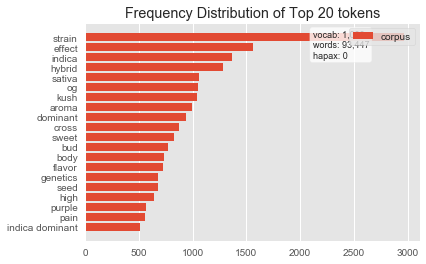

In [29]:
features   = bow.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n=20)
%time visualizer.fit(train_bow)
visualizer.poof()

In [30]:
lda_model = LatentDirichletAllocation(n_components=20, 
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=50, 
                                      learning_method='online', 
                                      random_state=123,
                                      n_jobs=-1,
                                      verbose=0)
%time lda_output = lda_model.fit(train_bow)


# Theta = document-topic matrix
# Beta = components_ = topic-term matrix
theta = pd.DataFrame(lda_model.transform(train_bow))
beta = pd.DataFrame(lda_model.components_)

Wall time: 34.7 s


In [31]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(train_bow))

Log Likelihood:  -588670.977362669


In [32]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(train_bow))

Perplexity:  544.3090168377048


In [33]:
# See model parameters
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 50, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'n_topics': None, 'perp_tol': 0.1, 'random_state': 123, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [34]:
# Define Search Param
#search_params = {'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [.3, .5, .7, .9], 'max_iter':[25,50,100,150,300,500,1000]}

# Define Search Param
search_params = {'n_components': [3, 5, 10, 15], 'learning_decay': [.3, .5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,cv=5)

# Do the Grid Search
model.fit(train_bow)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [3, 5, 10, 15], 'learning_decay': [0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(train_bow))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -122412.69416574787
Model Perplexity:  529.1701918267149


In [37]:
#How to see the dominant topic in each document?
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(train_bow)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_description_clean))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.74,0.25,0.01,0
Doc1,0.3,0.26,0.45,2
Doc2,0.33,0.01,0.66,2
Doc3,0.01,0.21,0.78,2
Doc4,0.49,0.32,0.19,0
Doc5,0.04,0.95,0.01,1
Doc6,0.23,0.3,0.47,2
Doc7,0.01,0.63,0.36,1
Doc8,0.97,0.02,0.02,0
Doc9,0.01,0.88,0.12,1


In [38]:
#Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,844
1,1,783
2,2,722
